In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import matplotlib
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, map_rx_config, map_tx_config, \
                        gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle

In [2]:
a = np.load('results/es5_collisionavoidance/es5_clearnight.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
clearnight_dbx = a['est_x_directbearing']
clearnight_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_clearday_directsun.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
cleardirsun_dbx = a['est_x_directbearing']
cleardirsun_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_clearday_indirectsun.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
clearday_indirectsun_dbx = a['est_x_directbearing']
clearday_indirectsun_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_rainday_directsun.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
rainday_directsun_dbx = a['est_x_directbearing']
rainday_directsun_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_rainday_indirectsun.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
rainday_indirectsun_dbx = a['est_x_directbearing']
rainday_indirectsun_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_rainnight.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
rainnight_dbx = a['est_x_directbearing']
rainnight_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_fogday_indirectsun.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
fogday_indirectsun_dbx = a['est_x_directbearing']
fogday_indirectsun_dry = a['est_y_directrange']

a = np.load('results/es5_collisionavoidance/es5_fognight.npz')
xRL_to_rxL = a['xRL_to_rxL']
yRL_to_rxL = a['yRL_to_rxL']
fognight_dbx = a['est_x_directbearing']
fognight_dry = a['est_y_directrange']

In [3]:
localization_decimation_rate = 10;
localization_num_steps = 270;
iterations = clearnight_dbx.shape[0]

In [4]:
e_clearnight_dbx           = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_clearnight_dry           = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_cleardirsun_dbx          = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_cleardirsun_dry          = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_clearday_indirectsun_dbx = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_clearday_indirectsun_dry = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainday_directsun_dbx    = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainday_directsun_dry    = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainday_indirectsun_dbx  = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainday_indirectsun_dry  = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainnight_dbx            = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_rainnight_dry            = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_fogday_indirectsun_dbx   = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_fogday_indirectsun_dry   = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_fognight_dbx             = np.zeros((iterations, localization_decimation_rate, localization_num_steps))
e_fognight_dry             = np.zeros((iterations, localization_decimation_rate, localization_num_steps))

for i in range(0, localization_num_steps):
    for j in range(0, localization_decimation_rate):
        for k in range(0, iterations):
            e_clearnight_dbx[k,j,i]             = clearnight_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]
            e_clearnight_dry[k,j,i]             = clearnight_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]
            e_cleardirsun_dbx[k,j,i]            = cleardirsun_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]          
            e_cleardirsun_dry[k,j,i]            = cleardirsun_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]          
            e_clearday_indirectsun_dbx[k,j,i]   = clearday_indirectsun_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j] 
            e_clearday_indirectsun_dry[k,j,i]   = clearday_indirectsun_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j] 
            e_rainday_directsun_dbx[k,j,i]      = rainday_directsun_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]    
            e_rainday_directsun_dry[k,j,i]      = rainday_directsun_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]    
            e_rainday_indirectsun_dbx[k,j,i]    = rainday_indirectsun_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]  
            e_rainday_indirectsun_dry[k,j,i]    = rainday_indirectsun_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]  
            e_rainnight_dbx[k,j,i]              = rainnight_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]            
            e_rainnight_dry[k,j,i]              = rainnight_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]            
            e_fogday_indirectsun_dbx[k,j,i]     = fogday_indirectsun_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]   
            e_fogday_indirectsun_dry[k,j,i]     = fogday_indirectsun_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]   
            e_fognight_dbx[k,j,i]               = fognight_dbx[k,i] - xRL_to_rxL[i*localization_decimation_rate + j]             
            e_fognight_dry[k,j,i]               = fognight_dry[k,i] - yRL_to_rxL[i*localization_decimation_rate + j]             


e_clearnight = np.sqrt(e_clearnight_dbx**2           + e_clearnight_dry**2)
e_cleardirsun = np.sqrt(e_cleardirsun_dbx**2          + e_cleardirsun_dry**2)
e_clearday_indirectsun = np.sqrt(e_clearday_indirectsun_dbx**2 + e_clearday_indirectsun_dry**2)
e_rainday_directsun = np.sqrt(e_rainday_directsun_dbx**2    + e_rainday_directsun_dry**2)
e_rainday_indirectsun = np.sqrt(e_rainday_indirectsun_dbx**2  + e_rainday_indirectsun_dry**2)
e_rainnight = np.sqrt(e_rainnight_dbx**2            + e_rainnight_dry**2)
e_fogday_indirectsun = np.sqrt(e_fogday_indirectsun_dbx**2   + e_fogday_indirectsun_dry**2)
e_fognight = np.sqrt(e_fognight_dbx**2             + e_fognight_dry**2)


In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [6]:
t = np.linspace(0, 2.7, 270)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


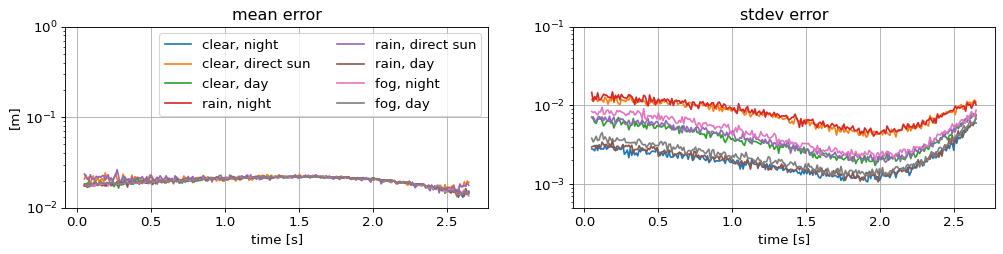

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15, 3), dpi=80)
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_clearnight,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_cleardirsun,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_clearday_indirectsun,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_rainnight,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_rainday_directsun,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_rainday_indirectsun,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_fognight,axis=0), axis=0)[5:-5])
ax[0].semilogy(t[5:-5],np.amax(np.mean(e_fogday_indirectsun,axis=0), axis=0)[5:-5])
ax[0].set_ylim([1e-2, 1e0])
ax[0].set_title('mean error')
ax[0].set_ylabel('[m]')
ax[0].set_xlabel('time [s]')
ax[0].legend(['clear, night','clear, direct sun','clear, day','rain, night','rain, direct sun','rain, day','fog, night','fog, day'], ncol=2)
ax[0].grid()
ax[1].semilogy(t[5:-5],np.amax(np.std(e_clearnight,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_cleardirsun,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_clearday_indirectsun,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_rainday_directsun,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_rainday_indirectsun,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_rainnight,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_fogday_indirectsun,axis=0), axis=0)[5:-5])
ax[1].semilogy(t[5:-5],np.amax(np.std(e_fognight,axis=0), axis=0)[5:-5])
ax[1].set_ylim([5e-4, 1e-1])
ax[1].set_xlabel('time [s]')
ax[1].set_title('stdev error')
ax[1].grid()
plt.savefig('es5.jpg', bbox_inches="tight")